# Titanic code

Import modules needed

In [1]:

from pathlib import Path

HOME_DIR = '..'
BASE_DIR = Path(HOME_DIR)

import sys
sys.path.append(HOME_DIR)

from config.config import DATA

PROJECT = '01_titanic'
FOLDER = 'processed'
FILE = 'processed_data.csv'

from src.modules.data_helper_functions import read_csv
from src.modules.graph_functions import plot_simple_scatter


In [2]:
file_path = BASE_DIR.joinpath(DATA).joinpath(PROJECT).joinpath(FOLDER).joinpath(FILE)
print('Data will be loaded from {file_path}')

Data will be loaded from {file_path}


In [3]:
data = read_csv(file_path)


In [4]:
print(data)

[{'passenger': 'Passenger1', 'raw_price': '8500', 'raw_cabin': '910', 'price': '0.85', 'cabin': '0.364', 'survived': '1'}, {'passenger': 'Passenger2', 'raw_price': '1200', 'raw_cabin': '2105', 'price': '0.12', 'cabin': '0.842', 'survived': '0'}, {'passenger': 'Passenger3', 'raw_price': '7800', 'raw_cabin': '1121', 'price': '0.78', 'cabin': '0.4484', 'survived': ''}]


In [5]:

labels, x, y = [], [], []

for row in data:
    labels.append(row['passenger'])
    x.append(float(row['price']))
    y.append(float(row['cabin']))

In [6]:
print(labels)
print(x)
print(y)

['Passenger1', 'Passenger2', 'Passenger3']
[0.85, 0.12, 0.78]
[0.364, 0.842, 0.4484]


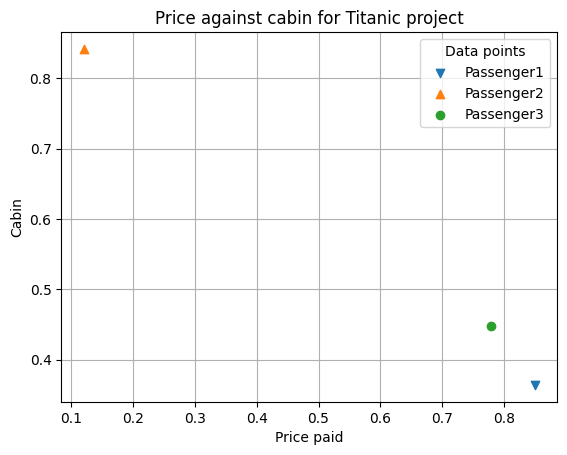

In [7]:
plot_simple_scatter(x, y, labels)